In [40]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("poster")


In [41]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [42]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10T18:52:32.159Z,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10T18:49:23.310Z,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10T16:40:16.050Z,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10T08:28:40.129Z,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [43]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10 18:52:32.159000+00:00,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10 18:49:23.310000+00:00,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10 16:40:16.050000+00:00,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10 08:28:40.129000+00:00,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [44]:
#adding column of converted time to datetime
model_df['Unix_Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix_Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [45]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix_Time


In [46]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix_Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
58103,-27.668500,-176.934500,25.08,4.60,1.652209e+09
58104,-59.013100,-25.575000,55.95,4.90,1.652209e+09
58105,34.731833,-119.073333,11.19,0.83,1.652201e+09
58106,2.945500,128.323100,53.98,4.50,1.652171e+09


In [47]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix_Time    0
dtype: int64

In [48]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [49]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix_Time    0
dtype: int64

In [50]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['Unix_Time'], axis = 1)

y = cleaned_df_dropped[['Unix_Time']]

In [51]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((58102, 4), (58102, 1))

In [52]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [54]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 27365151633013.7, 	R2 score: -0.36831752098282555, 	Model score: -0.36831752098282555
n_estimators=3:
	Mean Squared Error: 24620622254568.59, 	R2 score: -0.23108504057339885, 	Model score: -0.23108504057339885
n_estimators=4:
	Mean Squared Error: 23188001771404.32, 	R2 score: -0.15945087847112682, 	Model score: -0.15945087847112682
n_estimators=5:
	Mean Squared Error: 22482713268987.242, 	R2 score: -0.12418490851973929, 	Model score: -0.12418490851973929
n_estimators=6:
	Mean Squared Error: 21942935173244.926, 	R2 score: -0.09719482142824609, 	Model score: -0.09719482142824609
n_estimators=7:
	Mean Squared Error: 21618909623678.336, 	R2 score: -0.0809928342196986, 	Model score: -0.0809928342196986
n_estimators=8:
	Mean Squared Error: 21377219528263.56, 	R2 score: -0.06890780006242103, 	Model score: -0.06890780006242103
n_estimators=9:
	Mean Squared Error: 21108596225844.11, 	R2 score: -0.05547604656168881, 	Model score: -0.05547604656168881
n_estima

In [55]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,80):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 27365151633013.7, 	R2: -0.36831752098282555, 	Model score: -0.36831752098282555
n_estimators=3:
	Mean Squared Error: 24620622254568.59, 	R2: -0.23108504057339885, 	Model score: -0.23108504057339885
n_estimators=4:
	Mean Squared Error: 23188001771404.32, 	R2: -0.15945087847112682, 	Model score: -0.15945087847112682
n_estimators=5:
	Mean Squared Error: 22482713268987.242, 	R2: -0.12418490851973929, 	Model score: -0.12418490851973929
n_estimators=6:
	Mean Squared Error: 21942935173244.926, 	R2: -0.09719482142824609, 	Model score: -0.09719482142824609
n_estimators=7:
	Mean Squared Error: 21618909623678.336, 	R2: -0.0809928342196986, 	Model score: -0.0809928342196986
n_estimators=8:
	Mean Squared Error: 21377219528263.56, 	R2: -0.06890780006242103, 	Model score: -0.06890780006242103
n_estimators=9:
	Mean Squared Error: 21108596225844.11, 	R2: -0.05547604656168881, 	Model score: -0.05547604656168881
n_estimators=10:
	Mean Squared Error: 20949085305135.74,

Cross-Validation

In [56]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 5811  5812  5813 ... 58099 58100 58101] | test: [   0    1    2 ... 5808 5809 5810]
Train: [    0     1     2 ... 58099 58100 58101] | test: [ 5811  5812  5813 ... 11619 11620 11621]
Train: [    0     1     2 ... 58099 58100 58101] | test: [11622 11623 11624 ... 17429 17430 17431]
Train: [    0     1     2 ... 58099 58100 58101] | test: [17432 17433 17434 ... 23239 23240 23241]
Train: [    0     1     2 ... 58099 58100 58101] | test: [23242 23243 23244 ... 29049 29050 29051]
Train: [    0     1     2 ... 58099 58100 58101] | test: [29052 29053 29054 ... 34859 34860 34861]
Train: [    0     1     2 ... 58099 58100 58101] | test: [34862 34863 34864 ... 40669 40670 40671]
Train: [    0     1     2 ... 58099 58100 58101] | test: [40672 40673 40674 ... 46479 46480 46481]
Train: [    0     1     2 ... 58099 58100 58101] | test: [46482 46483 46484 ... 52289 52290 52291]
Train: [    0     1     2 ... 52289 52290 52291] | test: [52292 52293 52294 ... 58099 58100 58101]


In [57]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[-150.60780942  -14.5386014   -13.89328428  -15.3060583   -10.63964643
  -12.4315707   -12.40255603   -3.05893762 -153.93127753  -29.70615502]


In [58]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [59]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

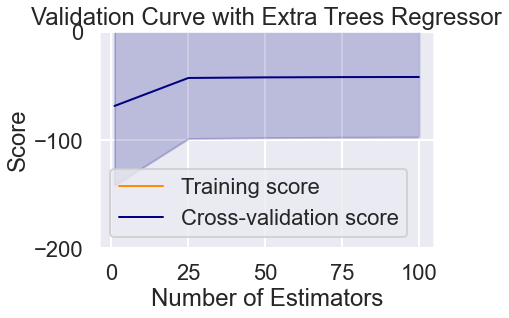

In [60]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(-200, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [61]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_time = y_test
time = actual_time['Unix_Time'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(time, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 4407181.953
MAE: 3572006.652


In [62]:
print(actual_time)

          Unix_Time
3616   1.640174e+09
13495  1.641524e+09
28367  1.645162e+09
31835  1.647184e+09
27553  1.645342e+09
...             ...
53210  1.650911e+09
52159  1.651210e+09
21480  1.644616e+09
44332  1.647977e+09
10617  1.642226e+09

[19174 rows x 1 columns]


In [63]:
time_pred = actual_time
time_pred['Predicted'] = testpredict


In [64]:
time_pred_all = time_pred.rename(columns={'Unix_Time': 'Actual'})

In [65]:
time_pred_all

,Actual,Predicted
3616,1.640174e+09,1.646962e+09
13495,1.641524e+09,1.645515e+09
28367,1.645162e+09,1.645995e+09
31835,1.647184e+09,1.649495e+09
27553,1.645342e+09,1.645047e+09
...,...,...
53210,1.650911e+09,1.649969e+09
52159,1.651210e+09,1.648344e+09
21480,1.644616e+09,1.647761e+09
44332,1.647977e+09,1.645453e+09


In [66]:
time_pred_all = time_pred_all.merge(model_df, how='inner', left_index=True, right_index=True)
time_pred_all = time_pred_all.rename(columns={'Unix_Time_x': 'Actual', 'Unix_Time_y': 'Unix_Time'})
time_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix_Time
3616,1.640174e+09,1.646962e+09,2021-12-22 11:53:28.400000+00:00,38.819833,-122.790667,1.25,1.14,md,43.0,26.00,...,"6km NNW of The Geysers, CA",earthquake,0.13,0.21,0.209000,10.0,reviewed,nc,nc,1.640174e+09
13495,1.641524e+09,1.645515e+09,2022-01-07 02:47:48.980000+00:00,38.824000,-122.763167,0.95,0.08,md,14.0,89.00,...,"4km W of Cobb, CA",earthquake,0.27,0.40,0.222000,3.0,reviewed,nc,nc,1.641524e+09
28367,1.645162e+09,1.645995e+09,2022-02-18 05:32:12.402000+00:00,38.163800,-117.914700,10.20,2.70,ml,22.0,103.56,...,"30 km SE of Mina, Nevada",earthquake,NaN,0.70,0.230000,9.0,reviewed,nn,nn,1.645162e+09
31835,1.647184e+09,1.649495e+09,2022-03-13 14:58:22.200000+00:00,17.972500,-66.977667,12.28,2.06,md,3.0,180.00,...,"6 km WSW of Fuig, Puerto Rico",earthquake,2.33,1.10,0.038064,3.0,reviewed,pr,pr,1.647184e+09
27553,1.645342e+09,1.645047e+09,2022-02-20 07:26:28.782000+00:00,62.942500,-151.285700,110.80,2.00,ml,NaN,NaN,...,"56 km NNW of Petersville, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak,1.645342e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53210,1.650911e+09,1.649969e+09,2022-04-25 18:16:17.945000+00:00,61.321200,-150.048100,46.90,1.10,ml,NaN,NaN,...,"5 km SW of Point MacKenzie, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak,1.650911e+09
52159,1.651210e+09,1.648344e+09,2022-04-29 05:24:32.810000+00:00,33.695000,-116.742000,14.98,0.19,ml,14.0,83.00,...,"5km SSW of Idyllwild, CA",earthquake,0.29,0.37,0.216000,5.0,reviewed,ci,ci,1.651210e+09
21480,1.644616e+09,1.647761e+09,2022-02-11 21:38:34.140000+00:00,33.866333,-117.495333,-0.48,1.19,ml,46.0,46.00,...,"3km ESE of Home Gardens, CA",quarry blast,0.30,31.61,0.109000,18.0,reviewed,ci,ci,1.644616e+09
44332,1.647977e+09,1.645453e+09,2022-03-22 19:20:34.790000+00:00,38.813835,-122.827835,1.87,0.85,md,16.0,59.00,...,"7km WNW of The Geysers, CA",earthquake,0.24,0.68,NaN,1.0,automatic,nc,nc,1.647977e+09


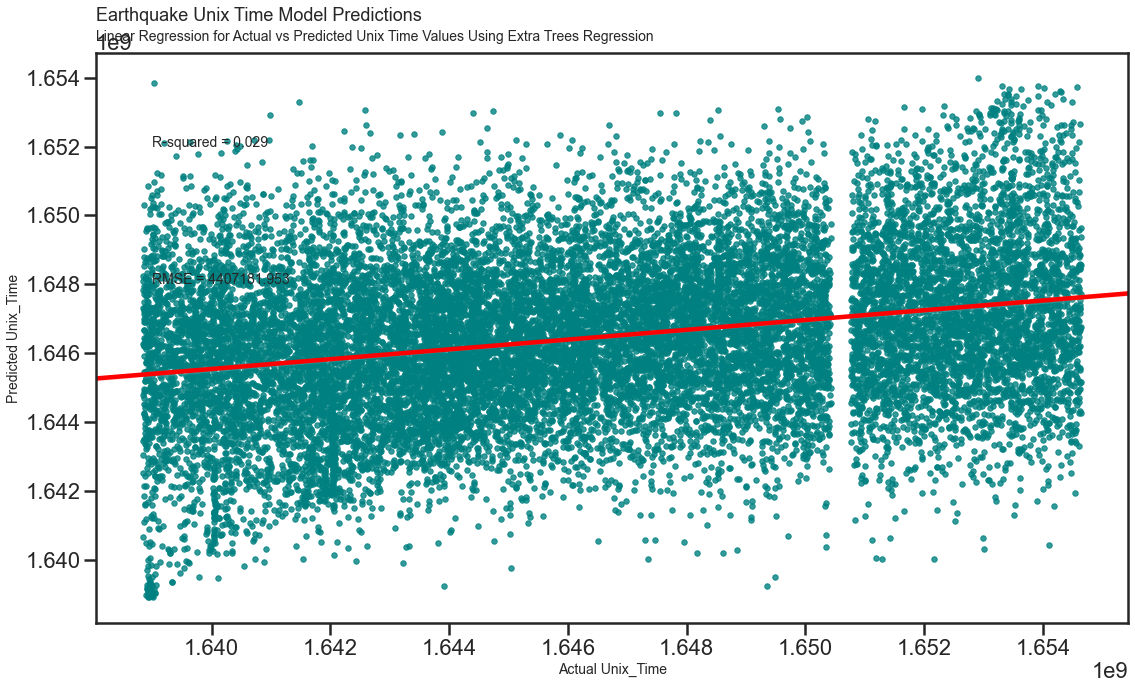

In [67]:

x = np.array(time_pred_all['Unix_Time'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Unix_Time', fontsize=14)
plt.xlabel('Actual Unix_Time',  fontsize=14)
# Bigger title
plt.suptitle('Earthquake Unix Time Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Unix Time Values Using Extra Trees Regression', x=0, y=1.01,loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(time_pred_all['Unix_Time'], testpredict)), (1.639*(10**9), 1.652*(10**9)),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (1.639*(10**9), 1.648*(10**9)), fontsize=14)

fig.savefig('../static/images/extratrees_time_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS

In [68]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-07-10T00:13:33.298Z,63.184200,-149.612500,74.00,1.60,ml,NaN,NaN,NaN,0.63,...,2022-07-10T00:15:55.647Z,"40 km SW of Cantwell, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
1,2022-07-09T23:56:25.810Z,19.274666,-155.778839,5.65,2.20,ml,19.0,242.0,NaN,0.25,...,2022-07-10T00:02:03.830Z,"22 km SSE of Honaunau-Napoopoo, Hawaii",earthquake,1.11,2.12,5.690000,3.0,automatic,hv,hv
2,2022-07-09T23:35:39.010Z,33.732500,-116.832000,14.56,0.49,ml,15.0,133.0,0.08894,0.21,...,2022-07-09T23:39:17.504Z,"6km ESE of Valle Vista, CA",earthquake,0.81,1.08,0.166000,12.0,automatic,ci,ci
3,2022-07-09T23:31:02.250Z,32.191167,-116.449000,24.00,1.77,ml,16.0,97.0,0.21870,0.15,...,2022-07-09T23:34:44.270Z,"39km NNE of Ensenada, B.C., MX",earthquake,0.43,1.23,0.261000,20.0,automatic,ci,ci
4,2022-07-09T23:30:43.950Z,17.945000,-66.971167,14.81,3.05,md,26.0,193.0,NaN,0.15,...,2022-07-10T00:05:44.810Z,"7 km WSW of Guánica, Puerto Rico",earthquake,0.33,0.41,0.204356,18.0,reviewed,pr,pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022-07-09T00:42:41.260Z,61.538100,-146.542200,29.80,1.90,ml,NaN,NaN,NaN,0.64,...,2022-07-09T00:44:35.005Z,"46 km NNW of Valdez, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
224,2022-07-09T00:38:30.731Z,18.866800,146.959900,10.00,4.70,mb,49.0,132.0,5.61800,0.51,...,2022-07-09T00:56:03.040Z,"Pagan region, Northern Mariana Islands",earthquake,6.50,1.80,0.086000,41.0,reviewed,us,us
225,2022-07-09T00:32:25.575Z,-22.413700,-66.202800,263.72,4.50,mb,29.0,77.0,1.90200,0.75,...,2022-07-09T03:13:28.040Z,"62 km WNW of Abra Pampa, Argentina",earthquake,10.40,10.60,0.140000,15.0,reviewed,us,us
226,2022-07-09T00:30:45.116Z,61.556900,-149.883200,35.10,1.40,ml,NaN,NaN,NaN,0.60,...,2022-07-09T00:32:09.545Z,"5 km NE of Big Lake, Alaska",earthquake,NaN,8.90,NaN,NaN,automatic,ak,ak


In [69]:

test_df['Unix_Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix_Time
0,63.184200,-149.612500,74.00,1.60,1.657412e+09
1,19.274666,-155.778839,5.65,2.20,1.657411e+09
2,33.732500,-116.832000,14.56,0.49,1.657410e+09
3,32.191167,-116.449000,24.00,1.77,1.657409e+09
4,17.945000,-66.971167,14.81,3.05,1.657409e+09
...,...,...,...,...,...
223,61.538100,-146.542200,29.80,1.90,1.657327e+09
224,18.866800,146.959900,10.00,4.70,1.657327e+09
225,-22.413700,-66.202800,263.72,4.50,1.657327e+09
226,61.556900,-149.883200,35.10,1.40,1.657327e+09


In [70]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix_Time    0
dtype: int64

In [71]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['Unix_Time'], axis = 1)

y_test_data = cleaned_test_df[['Unix_Time']]


In [72]:
pred_data_y = best_model.predict(X_test_data)

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix_Time,Predicted
0,63.184200,-149.612500,74.00,1.60,1.657412e+09,1.646957e+09
1,19.274666,-155.778839,5.65,2.20,1.657411e+09,1.647477e+09
2,33.732500,-116.832000,14.56,0.49,1.657410e+09,1.653475e+09
3,32.191167,-116.449000,24.00,1.77,1.657409e+09,1.647179e+09
4,17.945000,-66.971167,14.81,3.05,1.657409e+09,1.648332e+09
...,...,...,...,...,...,...
223,61.538100,-146.542200,29.80,1.90,1.657327e+09,1.645352e+09
224,18.866800,146.959900,10.00,4.70,1.657327e+09,1.646949e+09
225,-22.413700,-66.202800,263.72,4.50,1.657327e+09,1.647850e+09
226,61.556900,-149.883200,35.10,1.40,1.657327e+09,1.644559e+09


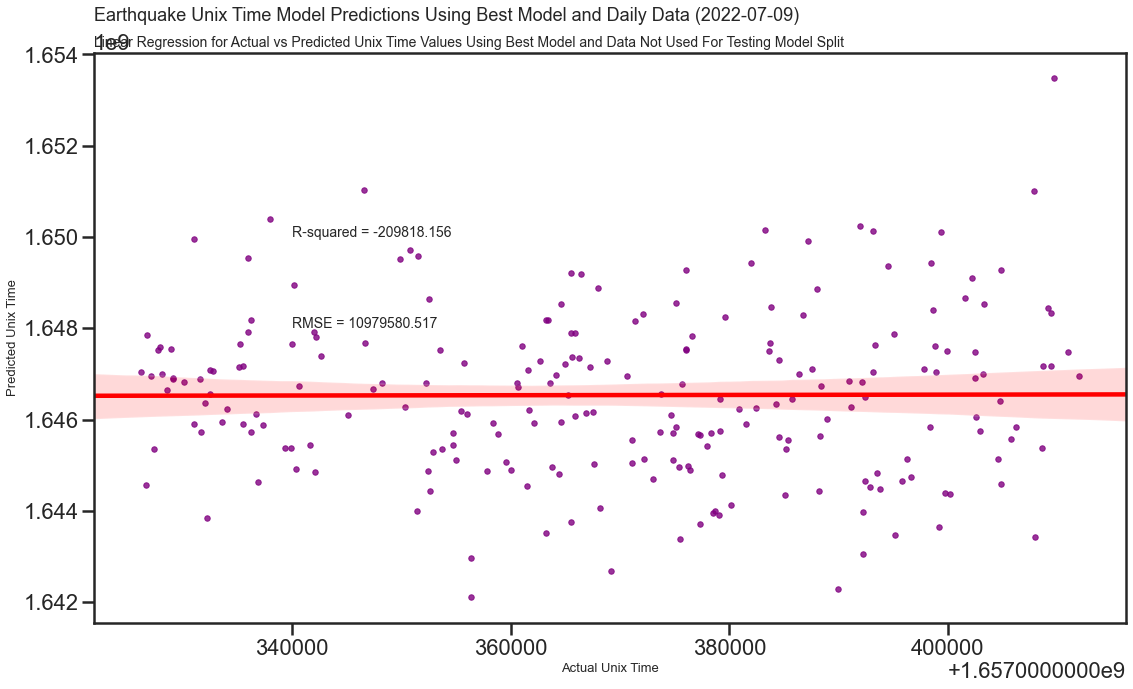

In [73]:
from datetime import date
today = date.today()

x = np.array(test_pred_data['Unix_Time'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Unix Time', fontsize=13)
plt.xlabel('Actual Unix Time',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Unix Time Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Unix Time Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (1.65734*(10**9), 1.650*(10**9)),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (1.65734*(10**9), 1.648*(10**9)), fontsize=14)

fig.savefig('../static/images/extratrees_time_linear_sns_daily.png', dpi=600)
plt.show()

In [74]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
time_pred_all.to_sql('earthquake_etrees_time', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
time_pred_all.to_sql('earthquake_etrees_time', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
